# COVID-19 Vaccine Twitter Exploratory Data Analysis

## Contents
1. [Imports](#1.-Imports)
2. [Load Clean Data](#2.-Load-Clean-Data)
3. [Date](#3.-Date)
    * [3.1 CDC Data: U.S Covid-19 Reported Cases](#3.1-CDC-Data:-U.S-Covid-19-Reported-Cases)
4. [Location](#4.-Location)
5. [Usernames](#5.-Usernames)
    * [5.1 CVS & Rite Aid Vaccine Finder](#5.1-CVS-&-Rite-Aid-Vaccine-Finder)
    * [5.2 I. R. Evangelista](#5.2-I.-R.-Evangelista)
    * [5.3 Adam](#5.3-Adam)
    * [5.4 Dirk Haussecker](#5.4-Dirk-Haussecker)
    * [5.5 Elizabeth](#5.5-Elizabeth)
6. [Frequency Distributions](#6.-Frequency-Distributions)
    * [6.1 Top 30 Tokens in Tweets](#6.1-Top-30-Tokens-in-Tweets)
    * [6.2 Top 30 Hashtags](#6.2-Top-30-Hashtags)
7. [WordClouds](#7.-WordClouds)
    * [7.1 Entire Corpus - Tokens & Hashtags](#7.1-Entire-Corpus---Tokens-&-Hashtags)
    * [7.2 Sample(n=1000): positive, negative, neutral](#7.2-Sample(n=1000):-positive,-negative,-neutral)
8. [NLP Feature Engineering](#9.-NLP-Feature-Engineering)
    * [8.1 Creating Text Features: char_count, word_count, avg_word_length](#8.1-Creating-Text-Features:-char_count,-word_count,-avg_word_length)
    * [8.2 Histogram/Density Plots w/ New Text Features](#8.2-Histogram/Density-Plots-w/-New-Text-Features)
        * [8.2.1 Sample(n=1000) w/ 3 classes: positive, negative, neutral](#8.2.1-Sample(n=1000)-w/-3-classes:-positive,-negative,-neutral)
        * [8.2.2 Sample(n=1000) w/ 4 classes: positive, negative, neutral, F/A](#8.2.2-Sample(n=1000)-w/-4-classes:-positive,-negative,-neutral,-F/A)

## 1. Imports

In [1]:
# Import packages
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Load Clean Data

In [2]:
# Load the cleaned data: 'covidvaccine_cleaned.csv'
df = pd.read_csv('../data/covidvaccine_cleaned.csv')

In [3]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_hashtags,clean_text
0,SouthSide,NaN,"‘ologist, Feminist, mother and grandmother. St...",2013-10-15 18:42:00,40.0,33.0,29884.0,True,2020-01-09 00:04:00,Don’t politicize the #CDC and the #FDA. I’m p...,"['CDC', 'FDA']",Twitter for iPhone,False,"cdc, fda",dont politicize the cdc and the fda im perfect...
1,Candidate PAJ,NaN,"Assuming Twitter exists in the future, let thi...",2019-01-18 02:06:00,2.0,166.0,41.0,True,2020-01-09 00:05:00,Whomever the President is needs to get the #co...,['covidvaccine'],Twitter for iPhone,False,covidvaccine,whomever the president is needs to get the cov...
2,💧Salty Noulty💧,"Brisbane, Australia","Inspiring carbon neutral living, science and h...",2007-09-28 19:20:00,398.0,602.0,11076.0,True,2020-01-09 00:09:00,@GregHuntMP You forgot to mention $5 million i...,['covidvaccine'],Twitter for iPhone,False,covidvaccine,you forgot to mention 5 million in funding fir...
3,PETER MAER,"Washington, DC",Retired White House Corr. \nEdward R. Murrow A...,2010-12-03 15:20:00,13514.0,11646.0,1563.0,True,2020-01-09 00:49:00,Is Trump pressuring #FDA for an October #Covid...,"['FDA', 'Covidvaccine']",Twitter Web App,False,"fda, covidvaccine",is trump pressuring fda for an october covidva...
4,B Sabs,NaN,Wife to my man of choice. Mother of 2 awesome ...,2014-09-09 16:09:00,100.0,316.0,19193.0,True,2020-01-09 00:59:00,Here we go. #COVIDvaccine https://t.co/FZgtcJ6XDP,['COVIDvaccine'],Twitter for iPhone,False,covidvaccine,here we go covidvaccine


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135322 entries, 0 to 135321
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_name         135322 non-null  object 
 1   user_location     107141 non-null  object 
 2   user_description  128259 non-null  object 
 3   user_created      135322 non-null  object 
 4   user_followers    135322 non-null  float64
 5   user_friends      135322 non-null  float64
 6   user_favourites   135322 non-null  float64
 7   user_verified     135322 non-null  bool   
 8   date              135322 non-null  object 
 9   text              135322 non-null  object 
 10  hashtags          135322 non-null  object 
 11  source            133108 non-null  object 
 12  is_retweet        135322 non-null  bool   
 13  clean_hashtags    135322 non-null  object 
 14  clean_text        135322 non-null  object 
dtypes: bool(2), float64(3), object(10)
memory usage: 13.7+ MB


In [5]:
# Set 'date' and 'user_created' columns as Datetime
df['date'] = pd.to_datetime(df.date)
df['user_created'] = pd.to_datetime(df.user_created)

## 3. Date

In [6]:
df['date'][0]

Timestamp('2020-01-09 00:04:00')

<br>

***

- **Note:** Data collection began on January 9, 2020. Let's check the number of tweets by year then by month to see the trend.

***

In [7]:
year_count = df['date'].groupby(df['date'].dt.year.rename('year')).agg('count')
print(year_count)

year
2020     25587
2021    109735
Name: date, dtype: int64


<br>

***

- **Note:** We can see that there has been around 4 times the number of tweets in 2021 than in year 2020. 

***

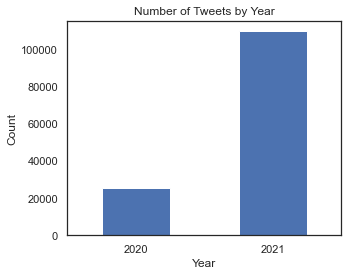

In [8]:
# sns.set(style='darkgrid')
sns.set(style='white')
ax1 = year_count.plot(kind='bar',figsize=(5,4))
ax1.set_title('Number of Tweets by Year')
ax1.set_xlabel('Year'); ax1.set_ylabel('Count')
ax1.set_xticklabels(labels=['2020','2021'],rotation=0)
plt.tight_layout();

In [9]:
year_month = df['date'].groupby([df['date'].dt.year.rename('year'),df['date'].dt.month.rename('month')]).agg('count')
year_month_idx = year_month.index
print(year_month)

year  month
2020  1           82
      2           86
      3          125
      4          124
      5           63
      6           56
      7           92
      8         2017
      9         1575
      10        1461
      11        9215
      12       10691
2021  1        41460
      2        37829
      3        20537
      4         9909
Name: date, dtype: int64


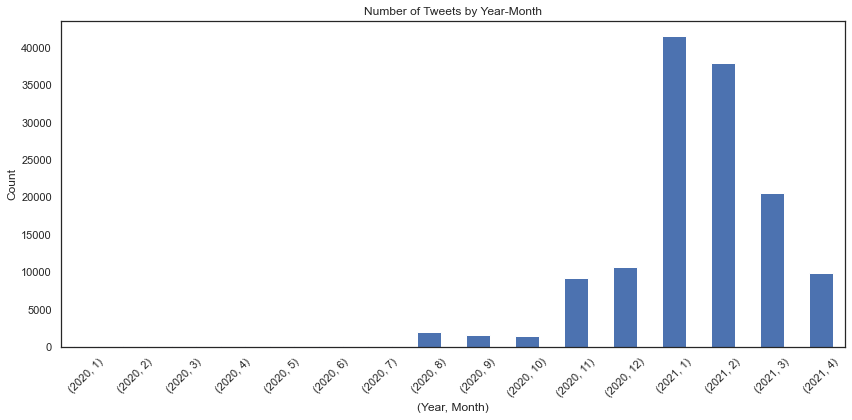

In [10]:
ax2 = year_month.plot(kind='bar',figsize=(12,6))
ax2.set_title('Number of Tweets by Year-Month')
ax2.set_xlabel('(Year, Month)')
ax2.set_ylabel('Count')
ax2.set_xticklabels(labels=year_month_idx,rotation=45)
plt.tight_layout();

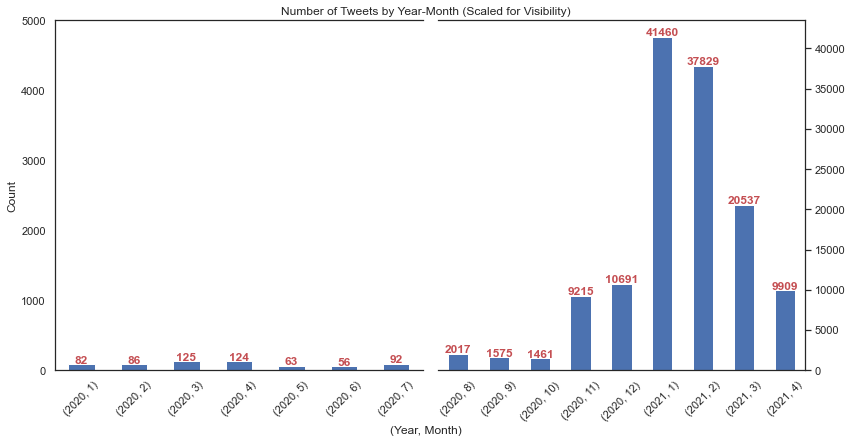

In [11]:
def addlabels(x,y,xa):
    for i in range(len(x)):
        if xa==0:
            ax[xa].text(i,y[i]+10,y[i],ha='center',c='r',fontsize=12,weight='bold')
        elif xa==1:
            ax[xa].text(i,y[i]+150,y[i],ha='center',c='r',fontsize=12,weight='bold')
        else:
            cx.text(i,y[i]+150,y[i],ha='center',c='r',fontsize=10)
            
fig,ax = plt.subplots(1,2,figsize=(12,6)) 
# fig.suptitle('Number of Tweets by Year-Month (Scaled for Visibility)',fontsize='medium')
fig.text(0.5,0.98,'Number of Tweets by Year-Month (Scaled for Visibility)',va='center',ha='center')
fig.text(0.5,0.01,'(Year, Month)',va='center',ha='center')
year_month[:7].plot(kind='bar',ax=ax[0])
year_month[7:].plot(kind='bar',ax=ax[1])
ax[0].set_ylim(0,5000)
ax[0].set(xlabel=None)
ax[0].set(ylabel='Count')
ax[0].set_xticklabels(labels=year_month[:7].index,rotation=45)
ax[0].spines.right.set_visible(False)
ax[1].set(xlabel=None)
ax[1].yaxis.tick_right()  
ax[1].set_xticklabels(labels=year_month[7:].index,rotation=45)
ax[1].spines.left.set_visible(False)
addlabels(year_month[:7].index,year_month[:7].values,0)
addlabels(year_month[7:].index,year_month[7:].values,1)
plt.tight_layout();
# plt.savefig('../images/yrmth_fdist.png')

In [12]:
# Top Percent Change by Year-Month
ym = pd.DataFrame(year_month).reset_index()
ym.rename({'date':'freq'},axis='columns',inplace=True)
ym['yr_mth']= ym['month'].map(str) + '-' + ym['year'].map(str)
ym = ym.drop(columns=['year','month'])
ym.set_index('yr_mth', inplace=True)
ym['norm'] = [float(i)/sum(ym.freq) for i in ym.freq]
ym['pct_chg'] = ym['norm'].pct_change(1).round(2)
print('Top Percentage Change in Tweets Counts from Jan 2020 to Apr 2021: ')
ym.pct_chg.nlargest(n=5)

# ym.sort_values(by=['pct_chg'],ascending=False).head(3)
# sns.lineplot(data=ym, x=ym.index,y='pct_chg')

Top Percentage Change in Tweets Counts from Jan 2020 to Apr 2021: 


yr_mth
8-2020     20.92
11-2020     5.31
1-2021      2.88
7-2020      0.64
3-2020      0.45
Name: pct_chg, dtype: float64

### 3.1 CDC Data: U.S Covid-19 Reported Cases 

In [13]:
# https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36/data
cases = pd.read_csv('../data/cdc_data.csv')
cases = cases[['submission_date','new_case']]
cases['submission_date'] = pd.to_datetime(cases.submission_date)
cases['m'] = cases['submission_date'].dt.month.rename('month')
cases['y'] = cases['submission_date'].dt.year.rename('year')

c_df = pd.DataFrame(cases.groupby(['y','m']).sum())
cval1 = c_df[:16].values.tolist()
cval2 = sum(cval1,[])

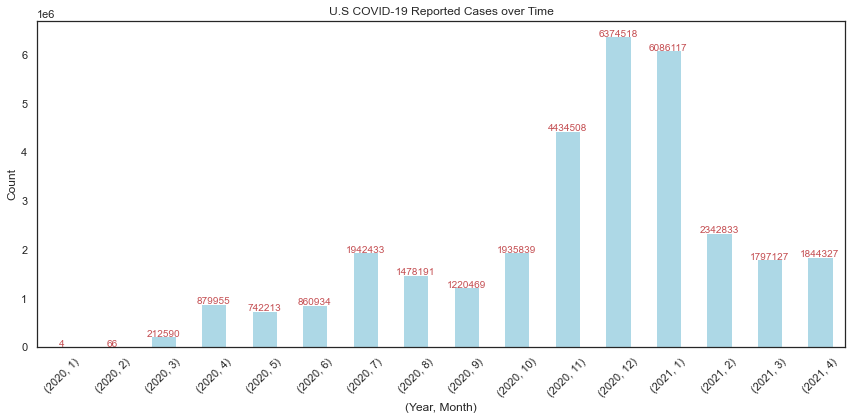

In [14]:
cx = c_df[:16].plot(kind='bar',figsize=(12,6),color='lightblue',legend=None)
cx.set_title('U.S COVID-19 Reported Cases over Time')
cx.set_xlabel('(Year, Month)')
cx.set_ylabel('Count')
cx.set_xticklabels(labels=c_df[:16].index,rotation=45)
addlabels(c_df[:16].index,cval2,3)
plt.tight_layout();
# plt.savefig('../images/cdc_cases.png')

<br>

***

- **Note:** Development for the Covid-19 vaccine began in March 2020 while the actual deployment of the vaccine in the US began in December 2020. We can also see that the distribution of tweets peaked in January 2021. We see the greatest percentage change increases in tweets from Jul-Aug (2020), Oct-Nov (2020), and Dec-Jan (2020/2021)— 20.92%, 5.31%, and 2.88%, respectively. We found data from the CDC to see if there are any noticable trends/patterns. We observe similar spikes in reported covid cases in the same months as we see the increases of tweet counts.

***

## 4. Location 

In [15]:
y = df['text'].groupby(df['user_location']).agg('count').sort_values(ascending=False)
y.sort_values(ascending=False).head(30)

user_location
India                      2651
United States              1843
London, England            1662
London                     1431
United Kingdom             1089
Washington, DC             1084
New Delhi, India            927
New York, NY                845
U.S.A.                      805
Los Angeles, CA             730
Chicago, IL                 723
UK                          683
Mumbai, India               662
England, United Kingdom     654
USA                         646
Boston, MA                  618
Canada                      577
Houston, TX                 542
Philadelphia, PA            473
Toronto, Ontario            470
Atlanta, GA                 469
New York                    459
London, UK                  449
New York, USA               419
California, USA             409
New Delhi                   384
Texas, USA                  380
England                     349
Ireland                     345
RNA World                   340
Name: text, dtype: int64

<br>

***

- **Note:** The user_location's column could use some cleaning up.

***

In [16]:
state_caps = {'AL':('Montgomery','Alabama'),'AK':('Juneau','Alaska'),'AS':('Pago Pago','American Samoa'),'AZ':('Phoenix','Arizona'),'AR':('Little Rock','Arkansas'),'CA':('Sacramento','California'),'CO':('Denver','Colorado'),'CT':('Hartford','Connecticut'),'DE':('Dover','Delaware'),'DC':('Washington DC','District of Columbia'),'FL':('Tallahassee','Florida'),'GA':('Atlanta','Georgia'),'GU':('Hagatna','Guam'),'HI':('Honolulu','Hawaii'),'ID':('Boise','Idaho'),'IL':('Springfield','Illinois'),'IN':('Indianapolis','Indiana'),'IA':('Des Monies','Iowa'),'KS':('Topeka','Kansas'),'KY':('Frankfort','Kentucky'),'LA':('Baton Rouge','Louisiana'),'ME':('Augusta','Maine'),'MD':('Annapolis','Maryland'),'MA':('Boston','Massachusetts'),'MI':('Lansing','Michigan'),'MN':('St. Paul','Minnesota'),'MS':('Jackson','Mississippi'),'MO':('Jefferson City','Missouri'),'MT':('Helena','Montana'),'NE':('Lincoln','Nebraska'),'NV':('Carson City','Nevada'),'NH':('Concord','New Hampshire'),'NJ':('Trenton','New Jersey'),'NM':('Santa Fe','New Mexico'),'NY':('Albany','New York'),'NC':('Raleigh','North Carolina'),'ND':('Bismarck','North Dakota'),'MP':('Northern Mariana Islands'),'OH':('Columbus','Ohio'),'OK':('Oklahoma City','Oklahoma'),'OR':('Salem','Oregon'),'PA':('Harrisburg','Pennsylvania'),'PR':('San Juan','Puerto Rico'),'RI':('Providence','Rhode Island'),'SC':('Columbia','South Carolina'),'SD':('Pierre','South Dakota'),'TN':('Nashville','Tennessee'),'TX':('Austin','Texas'),'UT':('Salt Lake City','Utah'),'VT':('Montpelier','Vermont'),'VI':('Virgin Islands'),'VA':('Richmond','Virginia'),'WA':('Olympia','Washington'),'WV':('Charleston','West Virginia'),'WI':('Madison','Wisconsin'),'WY':('Cheyenne','Wyoming'),'U.S.A.':('U.S','US')}

In [17]:
# Locations Counter
loc_counter = {}
def count_location(data):
    for i in data.dropna().values:
        if i.split(',')[-1].replace(' ','') in loc_counter:
            loc_counter[i.split(',')[-1].replace(' ','')]+=1
        else:
            loc_counter[i.split(',')[-1].replace(' ','')]=1
    return loc_counter

count_location(df['user_location'])
dict_loc = dict(sorted(loc_counter.items(),key=lambda x:x[1],reverse=True))

In [18]:
# Clean up locations
us = [k for k,v in dict_loc.items() if any(b in k.lower() for b in ['chicago','n.y','phila','losangeles','sandiego','carolina','unitedstate','newjersey','newy','washingtond','sanfrancisco'])]
uk = [k for k,v in dict_loc.items() if any(b in k.lower() for b in ['uk','unitedk','england','london'])]
can = [k for k,v in dict_loc.items() if any(b in k.lower() for b in ['canada','ontario'])]

for i in dict_loc.copy():
    for b,c,d,e in zip(state_caps.items(),us,uk,can):
        if i==b[0] or i==b[1][0] or i==b[1][1] or i==c:
            dict_loc['USA']+=dict_loc[i]
            del dict_loc[i]
        if i==d:
            if d=='UK': continue
            else:
                dict_loc['UK']+=dict_loc[i]
                del dict_loc[i]
        if i==e:
            if e=='Canada': continue
            else:
                dict_loc['Canada']+=dict_loc[i]
                del dict_loc[i]

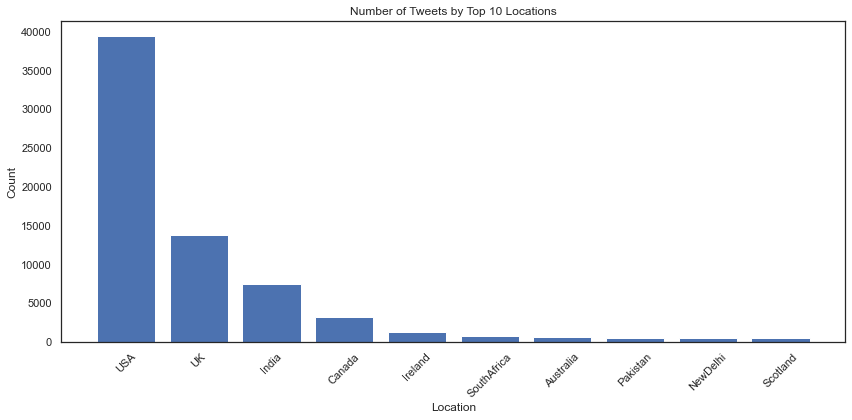

In [19]:
x_ax = list(dict_loc.keys())[:10]
y_ax = list(dict_loc.values())[:10]

list_tuples = list(zip(x_ax,y_ax))
df_loc = pd.DataFrame(list_tuples,columns=['location','counts'])
df_loc.sort_values(by='counts',ascending=False,inplace=True)

plt.figure(figsize=(12,6))
plt.bar(x='location',height='counts',data= df_loc)
plt.title('Number of Tweets by Top 10 Locations')
plt.xlabel('Location'); plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout();

<br>

***

- **Note:** There are ~40,000 tweets created from within the United States. However, we can see that there are still a good number of tweets created globally from the United Kingdom, India, Canada, etc.

***

## 5. Usernames

In [20]:
user_name = df['user_name'].value_counts().head(15)
print(user_name)

CVS & Rite Aid Vaccine Finder CA     1153
CVS & Rite Aid Vaccine Finder VA      805
I. R. Evangelista                     763
Dr. Akbar Niazi Teaching Hospital     268
Adam                                  263
Dirk Haussecker                       256
Elizabeth                             253
Covid India Seva                      249
PlacerCountyMuseums                   225
NDTV                                  213
CVS Vaccine Finder - Maryland         184
Mario NOT Luigi                       174
Khaleej Times                         174
IndiaToday                            168
Virgin Media News                     152
Name: user_name, dtype: int64


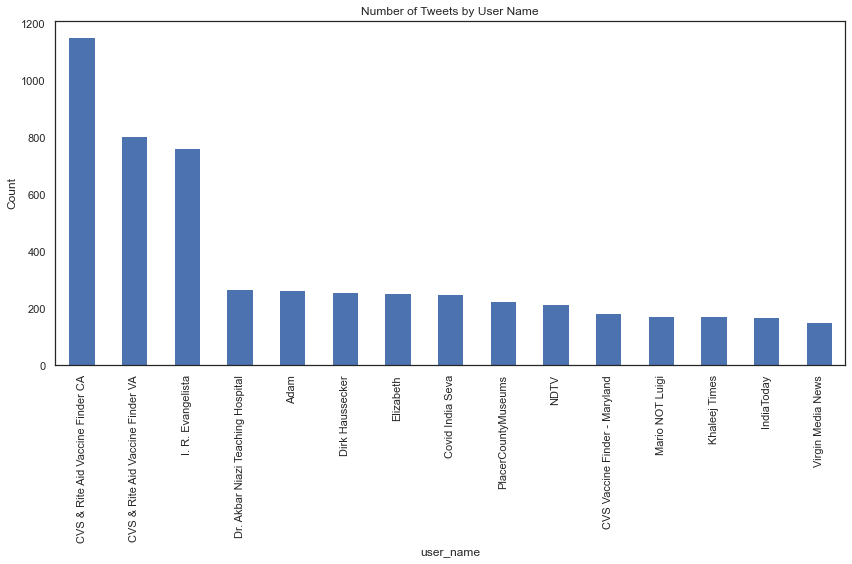

In [21]:
ax_3 = user_name.plot(kind='bar',figsize=(12,8))
# ax_3.invert_yaxis()
ax_3.set_title('Number of Tweets by User Name')
ax_3.set_ylabel('Count'); ax_3.set_xlabel('user_name')
plt.tight_layout();

<br>

***

- **Note:** Let's take a deeper dive into some of the tweets from the top user_names and see if we can infer sentiment.

***

### 5.1 CVS & Rite Aid Vaccine Finder

In [22]:
df[((df['user_name']=='CVS & Rite Aid Vaccine Finder CA')|(df['user_name']=='CVS & Rite Aid Vaccine Finder VA'))].head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_hashtags,clean_text
109556,CVS & Rite Aid Vaccine Finder CA,NaN,I'm a bot working to find CVS & Rite Aid #Vacc...,2021-02-13 18:55:00,1895.0,7.0,595.0,False,2021-03-18 14:16:00,34 CVS locations show #CovidVaccine slots in C...,['CovidVaccine'],NaN,False,covidvaccine,34 cvs locations show covidvaccine slots in ca...
109591,CVS & Rite Aid Vaccine Finder CA,NaN,I'm a bot working to find CVS & Rite Aid #Vacc...,2021-02-13 18:55:00,1895.0,7.0,595.0,False,2021-03-18 14:28:00,26 CVS locations show #CovidVaccine slots in C...,['CovidVaccine'],NaN,False,covidvaccine,26 cvs locations show covidvaccine slots in ca...
109651,CVS & Rite Aid Vaccine Finder CA,NaN,I'm a bot working to find CVS & Rite Aid #Vacc...,2021-02-13 18:55:00,1895.0,7.0,595.0,False,2021-03-18 14:46:00,18 CVS locations show #CovidVaccine slots in C...,['CovidVaccine'],NaN,False,covidvaccine,18 cvs locations show covidvaccine slots in ca...
109688,CVS & Rite Aid Vaccine Finder VA,NaN,Finder bot of CVS & Rite Aid #Vaccine appointm...,2021-02-12 20:20:00,1577.0,12.0,236.0,False,2021-03-18 15:01:00,6 CVS locations show #CovidVaccine slots in VA...,['CovidVaccine'],NaN,False,covidvaccine,6 cvs locations show covidvaccine slots in vad...
109690,CVS & Rite Aid Vaccine Finder CA,NaN,I'm a bot working to find CVS & Rite Aid #Vacc...,2021-02-13 18:55:00,1895.0,7.0,595.0,False,2021-03-18 15:01:00,9 CVS locations show #CovidVaccine slots in CA...,['CovidVaccine'],NaN,False,covidvaccine,9 cvs locations show covidvaccine slots in cab...


In [23]:
print(df['clean_text'].loc[((df['user_name']=='CVS & Rite Aid Vaccine Finder CA')|(df['user_name']=='CVS & Rite Aid Vaccine Finder VA'))].unique()[:10])

['34 cvs locations show covidvaccine slots in cabakersfieldbaldwin parkcamarillocloviscovinael centrofresno'
 '26 cvs locations show covidvaccine slots in cabakersfieldbaldwin parkcamarilloclovisfresnohanfordhighland'
 '18 cvs locations show covidvaccine slots in cabakersfieldclovisfresnohanfordhighlandkingsburgmaderamonteb'
 '6 cvs locations show covidvaccine slots in vadanvilleemporiahamptonlynchburgpulaskirichlands'
 '9 cvs locations show covidvaccine slots in cabakersfieldclovisfresnohanfordkingsburgmaderareedleysangersanta paula'
 '9 cvs locations show covidvaccine slots in cabakersfieldclovisfresnohanfordkingsburgmaderareedleysangersoledad'
 '5 cvs locations show covidvaccine slots in vadanvilleemporialynchburgpulaskirichlands'
 '7 cvs locations show covidvaccine slots in cabakersfieldfresnohanfordkingsburgmaderareedleysanger'
 '6 cvs locations show covidvaccine slots in cafresnohanfordkingsburgmaderareedleysanger'
 '6 cvs locations show covidvaccine slots in cabakersfieldfresnoh

<br>

***

- **Note:** The top 2 usernames with the most number of tweets are by CVS & Rite Aid Vaccine Finder - CA and CVS & Rite Aid Vaccine Finder VA . We can see that the tweets from these usernames are, in fact, bots that are tweeting information regarding the number of vaccine slots available at certain CVS locations. We can regard these tweets as having 'Neutral' sentiment.

***

### 5.2 I. R. Evangelista 

In [24]:
df[df['user_name']=='I. R. Evangelista'].head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_hashtags,clean_text
10374,I. R. Evangelista,U.S.A.,A computer programmer experienced on Medical C...,2009-10-25 22:37:00,1789.0,4908.0,25257.0,True,2020-11-16 22:43:00,"@iocmedia Hello, #IOC, can you please postpone...","['IOC', 'TokyoOlympics', 'ParisOlympics', 'LAO...",Twitter Web App,False,"ioc, tokyoolympics, parisolympics, laolympics,...",hello ioc can you please postpone the tokyooly...
10402,I. R. Evangelista,U.S.A.,A computer programmer experienced on Medical C...,2009-10-25 22:37:00,1789.0,4908.0,25257.0,True,2020-11-16 23:55:00,@kuko35570287 @JoeBiden Please postpone the #T...,"['TokyoOlympics', 'ParisOlympics', 'LAOlympics...",Twitter Web App,False,"tokyoolympics, parisolympics, laolympics, 2024...",please postpone the tokyoolympics parisolympic...
10403,I. R. Evangelista,U.S.A.,A computer programmer experienced on Medical C...,2009-10-25 22:37:00,1789.0,4908.0,25257.0,True,2020-11-16 23:55:00,@marcosarellano Please postpone the #TokyoOlym...,"['TokyoOlympics', 'ParisOlympics', 'LAOlympics...",Twitter Web App,False,"tokyoolympics, parisolympics, laolympics, 2024...",please postpone the tokyoolympics parisolympic...
10404,I. R. Evangelista,U.S.A.,A computer programmer experienced on Medical C...,2009-10-25 22:37:00,1789.0,4908.0,25257.0,True,2020-11-16 23:55:00,@NathalieStucky Please postpone the #TokyoOlym...,"['TokyoOlympics', 'ParisOlympics', 'LAOlympics...",Twitter Web App,False,"tokyoolympics, parisolympics, laolympics, 2024...",please postpone the tokyoolympics parisolympic...
10405,I. R. Evangelista,U.S.A.,A computer programmer experienced on Medical C...,2009-10-25 22:37:00,1789.0,4908.0,25257.0,True,2020-11-16 23:55:00,@TelanganaToday Please postpone the #TokyoOlym...,"['TokyoOlympics', 'ParisOlympics', 'LAOlympics...",Twitter Web App,False,"tokyoolympics, parisolympics, laolympics, 2024...",please postpone the tokyoolympics parisolympic...


In [25]:
print(df['clean_text'].loc[df['user_name']=='I. R. Evangelista'].unique()[:10])

['hello ioc can you please postpone the tokyoolympics parisolympics and laolympics to 2024year'
 'please postpone the tokyoolympics parisolympics and laolympics to 2024year 2028year'
 'please postpone the tokyoolympics parisolympics and laolympics to 2024year 2028year and'
 'please postpone the tokyoolympics parisolympics and laolympics to 2024year 2028year and 2032year c'
 'please postpone the tokyoolympics parisolympics and laolympics to 2024year 2028year and 2032year'
 'please postpone the tokyoolympics parisolympics and laolympics to 2024year'
 'please postpone the tokyoolympics parisolympics and laolympics to 2024year 2028year and 2032year e'
 'please postpone the tokyoolympics parisolympics and'
 'please postpone the tokyoolympics parisolympics and laolympics to'
 'please postpone the tokyoolympics parisolympics and laolympics to 2024year 2028year and 2032year ea']


<br>

***

- **Note:** We can't really infer much about the tweets from I. R. Evangelista. It seems that this user wants to postpone the upcoming Olympics, but doesn't really have anything to say about the covid vaccine in particular. Thus, we will regard these tweets as having 'Neutral' sentiment.

***

### 5.3 Adam 

In [26]:
df[df['user_name']=='Adam'].head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_hashtags,clean_text
21593,Adam,"Baltimore, MD USA",Revelation 14:6-12 Third Angels Message,2010-08-24 21:48:00,2687.0,4254.0,2090.0,True,2020-12-30 13:37:00,@Mike_Pence #vaccines #CovidVaccine #Covid \n\...,"['vaccines', 'CovidVaccine', 'Covid']",Twitter for iPad,False,"vaccines, covidvaccine, covid",vaccines covidvaccine covid 2 timothy 313but e...
21601,Adam,"Baltimore, MD USA",Revelation 14:6-12 Third Angels Message,2010-08-24 21:48:00,2687.0,4254.0,2090.0,True,2020-12-30 13:38:00,@Mike_Pence #vaccines #CovidVaccine #Covid \n\...,"['vaccines', 'CovidVaccine', 'Covid']",Twitter for iPad,False,"vaccines, covidvaccine, covid",vaccines covidvaccine covid 2 timothy 313but e...
21605,Adam,"Baltimore, MD USA",Revelation 14:6-12 Third Angels Message,2010-08-24 21:48:00,2687.0,4254.0,2090.0,True,2020-12-30 13:39:00,@Mike_Pence #vaccines #CovidVaccine #Covid \n\...,"['vaccines', 'CovidVaccine', 'Covid']",Twitter for iPad,False,"vaccines, covidvaccine, covid",vaccines covidvaccine covid 2 timothy 313but e...
21612,Adam,"Baltimore, MD USA",Revelation 14:6-12 Third Angels Message,2010-08-24 21:48:00,2687.0,4254.0,2090.0,True,2020-12-30 13:40:00,@Mike_Pence #vaccines #CovidVaccine #Covid \n\...,"['vaccines', 'CovidVaccine', 'Covid']",Twitter for iPad,False,"vaccines, covidvaccine, covid",vaccines covidvaccine covid 2 timothy 313but e...
21615,Adam,"Baltimore, MD USA",Revelation 14:6-12 Third Angels Message,2010-08-24 21:48:00,2687.0,4254.0,2090.0,True,2020-12-30 13:41:00,@Mike_Pence #vaccines #CovidVaccine #Covid \n\...,"['vaccines', 'CovidVaccine', 'Covid']",Twitter for iPad,False,"vaccines, covidvaccine, covid",vaccines covidvaccine covid 2 timothy 313but e...


In [27]:
print(df['clean_text'].loc[df['user_name']=='Adam'].unique()[:10])

['vaccines covidvaccine covid 2 timothy 313but evil men and seducers shall wax worse and worsed'
 'skynews covidvaccine covid 2 timothy 313but evil men and seducers shall wax worse and worsedeceiv'
 'its all about the benjamins baby covidvaccine covid19'
 'only 267000000 people ahead of me for the covidvaccine so really any day now'
 'covid19 covid covidvaccine 01the destruction of jerusalem great controversy 1911 ellen g w'
 'covid19 covid covidvaccine 01the destruction of jerusalem great controversy 1911 ellen g whi'
 'covid19 covid covidvaccine 01the destruction of jerusalem great'
 'terrorism jesuits vatican covid19 covidvaccine 01the destruction of jerusalem great controversy'
 'terrorism covidvaccine maskup covidisairborne global covid terrorism by vatican orchestrated with sa'
 'terrorism covidvaccine maskup covidisairborne global covid terrorism by vatican orchestrated with satanic ar']


<br>

***

- **Note:** Adam is associating 'covidvaccine' with 'terrorism' and 'the agenda of evil'. We can regard these tweets as having 'Negative' sentiment.

***

### 5.4 Dirk Haussecker 

In [28]:
df[df['user_name']=='Dirk Haussecker'].head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_hashtags,clean_text
26,Dirk Haussecker,RNA World,RNA(i) Therapeutics Investor-Scientist who lov...,2011-10-11 12:00:00,9354.0,340.0,7298.0,True,2020-01-09 08:48:00,As #covidvaccine pIII trials read out --&gt; $...,"['covidvaccine', 'Oxford']",Twitter Web App,False,"covidvaccine, oxford",as covidvaccine piii trials read out gt mrna b...
40,Dirk Haussecker,RNA World,RNA(i) Therapeutics Investor-Scientist who lov...,2011-10-11 12:00:00,9354.0,340.0,7298.0,True,2020-01-09 14:42:00,"#covid19 Be it #covidvaccine, IL-6 drugs... a ...","['covid19', 'covidvaccine']",Twitter Web App,False,"covid19, covidvaccine",covid19 be it covidvaccine il6 drugs a pattern...
59,Dirk Haussecker,RNA World,RNA(i) Therapeutics Investor-Scientist who lov...,2011-10-11 12:00:00,9354.0,340.0,7298.0,True,2020-01-09 19:25:00,Oxford/AZ chimp adenovirus-based #covidvaccine...,['covidvaccine'],Twitter Web App,False,covidvaccine,oxfordaz chimp adenovirusbased covidvaccine ha...
102,Dirk Haussecker,RNA World,RNA(i) Therapeutics Investor-Scientist who lov...,2011-10-11 12:00:00,9374.0,342.0,7341.0,True,2020-02-09 07:42:00,The weakest #covidvaccine candidate w/ lots of...,"['covidvaccine', 'CanSino']",Twitter Web App,False,"covidvaccine, cansino",the weakest covidvaccine candidate w lots of p...
130,Dirk Haussecker,RNA World,RNA(i) Therapeutics Investor-Scientist who lov...,2011-10-11 12:00:00,9374.0,342.0,7341.0,True,2020-02-09 14:05:00,'Independent group'....let's see how many of t...,['covidvaccine'],Twitter Web App,False,covidvaccine,independent grouplets see how many of them wil...


In [29]:
print(df['clean_text'].loc[df['user_name']=='Dirk Haussecker'].unique()[:10])

['as covidvaccine piii trials read out gt mrna bntx pfe oxford critical if there is inverse correlation of nab'
 'covid19 be it covidvaccine il6 drugs a pattern is emerging while china russia rush to approve russia ofte'
 'oxfordaz chimp adenovirusbased covidvaccine hardly produced neutralizing antibodies comparable to asymptomatics'
 'the weakest covidvaccine candidate w lots of preexisting ad5 immunity issues both oxfordaz and cansino aden'
 'independent grouplets see how many of them will have links to pfe az and mrna covidvaccine'
 'covidvaccine given that piii trials look at prevention of symptomatic disease my bet is that initial positive dat'
 'sanofigsk rec protein covidvaccinehave distinct impression nvax nanoparticle formulation more potentsanofi'
 'jnj ad26 covidvaccine hamster model for severe disease1 shot provides protection but not sterilizing comforti'
 'covidvaccine cepifunded australian lab doing comparative vaccine efficacy studies for downselection'
 'nvax covidvacc

<br>

***

- **Note:** Dirk Haussecker's tweets are informational tweets with a slight sceptism and doubt. For now, we can regard this user's tweets as 'Neutral'; however, we may need to revisit our sentiment labeling rules in the future.

***

### 5.5 Elizabeth

In [30]:
df[df['user_name']=='Elizabeth'].head(15)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,clean_hashtags,clean_text
3324,Elizabeth,"Ohio, USA",Ready to live in the woods! Being an #Empath i...,2018-01-04 02:22:00,309.0,903.0,3799.0,True,2020-09-16 22:28:00,I dont trust a rushed vaccine either. \n#Trump...,"['TrumpLied200KDied', 'COVID19', 'CovidVaccine...",Twitter for Android,False,"trumplied200kdied, covid19, covidvaccine, bide...",i dont trust a rushed vaccine either trumplied...
15149,Elizabeth,"West Bengal, India","I Colour Outside The Line, See Outside The Box...",2019-07-26 14:51:00,11446.0,2007.0,29634.0,True,2020-12-08 13:57:00,President @realDonaldTrump to @KremlinRussia_E...,['CovidVaccine'],Twitter for Android,False,covidvaccine,president to after russia invented covidvaccine
16130,Elizabeth,NaN,NaN,2020-09-30 23:29:00,1.0,12.0,6.0,True,2020-12-26 19:51:00,"Anecdotally, decreasing milk supply in a #brea...","['breastfeeding', 'CovidVaccine']",Twitter Web App,False,"breastfeeding, covidvaccine",anecdotally decreasing milk supply in a breast...
21795,Elizabeth,USA,30 something from the Philadelphia area. She/Her.,2010-06-25 00:37:00,263.0,1928.0,73068.0,True,2020-12-30 14:30:00,Very accurate and still stands now since I can...,['Mitchmcconell'],Twitter for iPhone,False,mitchmcconell,very accurate and still stands now since i can...
22493,Elizabeth,USA,30 something from the Philadelphia area. She/Her.,2010-06-25 00:37:00,263.0,1928.0,73068.0,True,2020-12-30 17:23:00,"Hello, this is a shit show. #COVID19 #CovidVac...","['COVID19', 'CovidVaccine', 'OperationWarpSpeed']",Twitter for iPhone,False,"covid19, covidvaccine, operationwarpspeed",hello this is a shit show covid19 covidvaccine...
33951,Elizabeth,Far away from #DictatorDan,"The only thing worse than our politicians, are...",2009-11-27 08:21:00,2381.0,2004.0,46688.0,True,2021-01-13 01:13:00,#InformedConsent for any #CovidVaccine is your...,"['InformedConsent', 'CovidVaccine']",Twitter Web App,False,"informedconsent, covidvaccine",informedconsent for any covidvaccine is your r...
36095,Elizabeth,Far away from #DictatorDan,"The only thing worse than our politicians, are...",2009-11-27 08:21:00,2381.0,2004.0,46688.0,True,2021-01-13 21:32:00,#InformedConsent for any #CovidVaccine is your...,"['InformedConsent', 'CovidVaccine']",Twitter Web App,False,"informedconsent, covidvaccine",informedconsent for any covidvaccine is your r...
38896,Elizabeth,Far away from #DictatorDan,"The only thing worse than our politicians, are...",2009-11-27 08:21:00,2381.0,2004.0,46688.0,True,2021-01-14 22:17:00,#InformedConsent for any #CovidVaccine is your...,"['InformedConsent', 'CovidVaccine']",Twitter Web App,False,"informedconsent, covidvaccine",informedconsent for any covidvaccine is your r...
39445,Elizabeth,Far away from #DictatorDan,"The only thing worse than our politicians, are...",2009-11-27 08:21:00,2381.0,2004.0,46688.0,True,2021-01-15 05:07:00,#CovidVaccine \n\n23 Dead In Norway After COVI...,['CovidVaccine'],Twitter Web App,False,covidvaccine,covidvaccine 23 dead in norway after covid vac...
39451,Elizabeth,Far away from #DictatorDan,"The only thing worse than our politicians, are...",2009-11-27 08:21:00,2381.0,2004.0,46688.0,True,2021-01-15 05:10:00,#CovidVaccine #COVIDー19 \n\n23 Dead In Norway ...,"['CovidVaccine', 'COVIDー19']",Twitter Web App,False,"covidvaccine, covid19",covidvaccine covid19 23 dead in norway after c...


<br>

***

**Note:** We can see that there are several users using the user_name Elizabeth with different user_location and  user_created values. Let's take a further look.

***

In [31]:
df_elizabeth = df[df['user_name']=='Elizabeth']
df_elizabeth['user_name'].groupby([df_elizabeth['user_location'],df_elizabeth['user_created']]).agg('count').sort_values(ascending=False)

user_location                 user_created       
Far away from #DictatorDan    2009-11-27 08:21:00    241
USA                           2010-06-25 00:37:00      2
Washington, DC                2017-01-30 15:41:00      2
313                           2009-04-14 17:09:00      1
Bay Area, CA                  2019-07-03 07:30:00      1
Ohio, USA                     2018-01-04 02:22:00      1
West Bengal, India            2019-07-26 14:51:00      1
Name: user_name, dtype: int64

<br>

***

- **Note:** We can see that 241 tweets are made by the same Elizabeth. We will go ahead and take a look at the tweets from this specific Elizabeth.

***

In [32]:
print(df_elizabeth['clean_text'].loc[df_elizabeth['user_created']=='2009-11-27 08:21:00'].unique()[:10])

['informedconsent for any covidvaccine is your right dont be forced or coerced into taking a vaccine that may not'
 'covidvaccine 23 dead in norway after covid vaccinations reports medicines agency'
 'covidvaccine covid19 23 dead in norway after covid vaccinations reports medicines agency'
 'its time to start asking msm in australia why they are not reporting on covidvaccine side effects'
 'we are not guinea pigs deaths amp side effects are being reported worldwide after taking a covidvaccine a safe vax'
 'just how safe is any covidvaccine that was allowed to skip animal trials when such trials are essential in determ'
 'why are our msm not reporting on covidvaccine side effects'
 'covidvaccine deaths and side effectsvaerscdc is now reporting 181 deaths and 7844 cases with side effects'
 'covidvaccine fauci said second covid19 vaccine shot knocked him out for 24 hours'
 'how safe is any covidvaccine that was allowed to skip animal trials when such trials are essential']


<br>

***

- **Note:** Elizabeth, with the user_location: Far away from #DictatorDan, is tweeting with negative sentiment.

***

## 6. Frequency Distributions

### 6.1 Top 30 Tokens in Tweets

Frequency Distinct - top 30 terms/tokens WITH stopwords:

[('the', 70820), ('covidvaccine', 65544), ('to', 50866), ('of', 32422), ('in', 28522), ('a', 27126), ('and', 25976), ('for', 24171), ('covid19', 22718), ('is', 22502), ('vaccine', 22081), ('you', 15102), ('my', 14966), ('on', 12965), ('i', 11531), ('are', 11288), ('this', 10726), ('get', 10466), ('be', 10182), ('have', 10024), ('it', 9244), ('that', 8892), ('with', 8754), ('covid', 8688), ('at', 8081), ('first', 7703), ('from', 7327), ('will', 7265), ('not', 7149), ('about', 7091), ('we', 6768), ('amp', 6659), ('your', 6629)]

Frequency Distinct - top 30 terms/tokens WITHOUT stopwords:

[('covidvaccine', 65544), ('covid19', 22718), ('vaccine', 22081), ('covid', 8688), ('first', 7703), ('will', 7265), ('amp', 6659), ('dose', 6164), ('today', 5694), ('people', 5484), ('got', 5389), ('now', 4396), ('vaccination', 4194), ('vaccinated', 4127), ('vaccines', 4039), ('getting', 3925), ('one', 3744), ('coronavirus', 3394), ('shot', 3262)

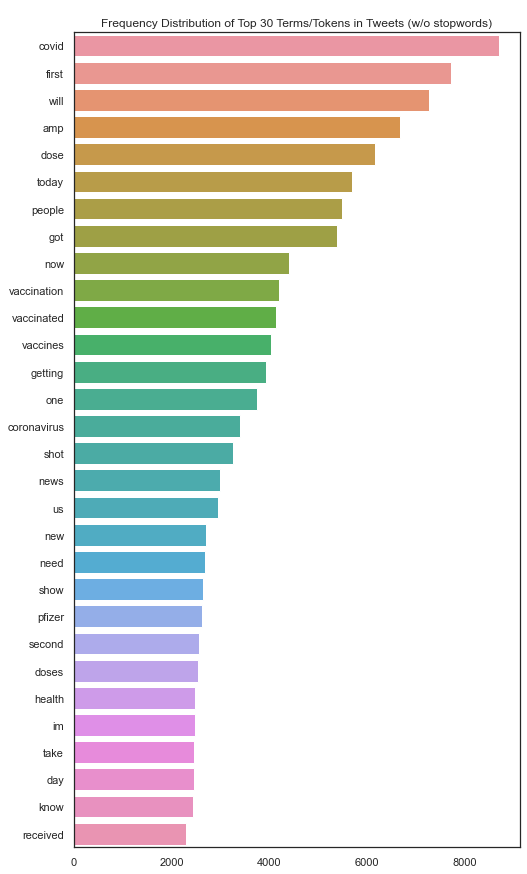

In [33]:
# frequency distinct: top 30 tweeted words W/ stopwords
all_tweets = ''.join(df['clean_text'].values)
token_tweets = word_tokenize(all_tweets)
fdist_tweets = FreqDist(token_tweets).most_common(33)
print('Frequency Distinct - top 30 terms/tokens WITH stopwords:\n')
print(fdist_tweets)

# frequency distinct: top 30 tweeted words W/O stopwords
stop_words_tweets = set(STOPWORDS)
token_tweets_nostop = [w for w in token_tweets if w not in stop_words_tweets]
fdist_tweets_nostop = FreqDist(token_tweets_nostop).most_common(33)
fseries_tweets_nostop = pd.Series(dict(fdist_tweets_nostop[3:33]))
print('\nFrequency Distinct - top 30 terms/tokens WITHOUT stopwords:\n')
print(fdist_tweets_nostop)

# frequency distribution plot
fig,ax = plt.subplots(figsize=(8,15))
sns.barplot(y=fseries_tweets_nostop.index,x=fseries_tweets_nostop.values,ax=ax,orient='h')
plt.title('\nFrequency Distribution of Top 30 Terms/Tokens in Tweets (w/o stopwords)')
plt.tight_layout;

### 6.2 Top 30 Hashtags

Frequency Distinct - top 30 #hashtags:

[(',', 137493), ('covidvaccine', 12803), ('covid19', 7474), ('covidvaccinecovidvaccine', 2951), ('covid', 1879), ('vaccine', 1722), ('coronavirus', 1717), ('covidvaccinecovid19', 1572), ('covidvaccinecovidvaccinecovidvaccine', 1060), ('parisolympics', 732), ('laolympics', 679), ('covid19covidvaccine', 645), ('pfizer', 586), ('2024year', 530), ('covidvaccinecovidvaccinecovid19', 483), ('covid19uk', 459), ('vaccinated', 457), ('moderna', 446), ('vaccination', 431), ('2028yeartokyoolympics', 428), ('astrazeneca', 427), ('covidvaccinecovidvaccinecovidvaccinecovidvaccine', 388), ('covid19vaccine', 380), ('vaccines', 362), ('covid19covid19', 325), ('covidvaccination', 320), ('india', 312), ('corona', 267), ('pandemic', 258), ('coronavaccine', 258), ('covidvaccinecovid', 238), ('pfizervaccine', 236), ('covidvaccinecovidvaccinecovidvaccinecovid19', 234)]


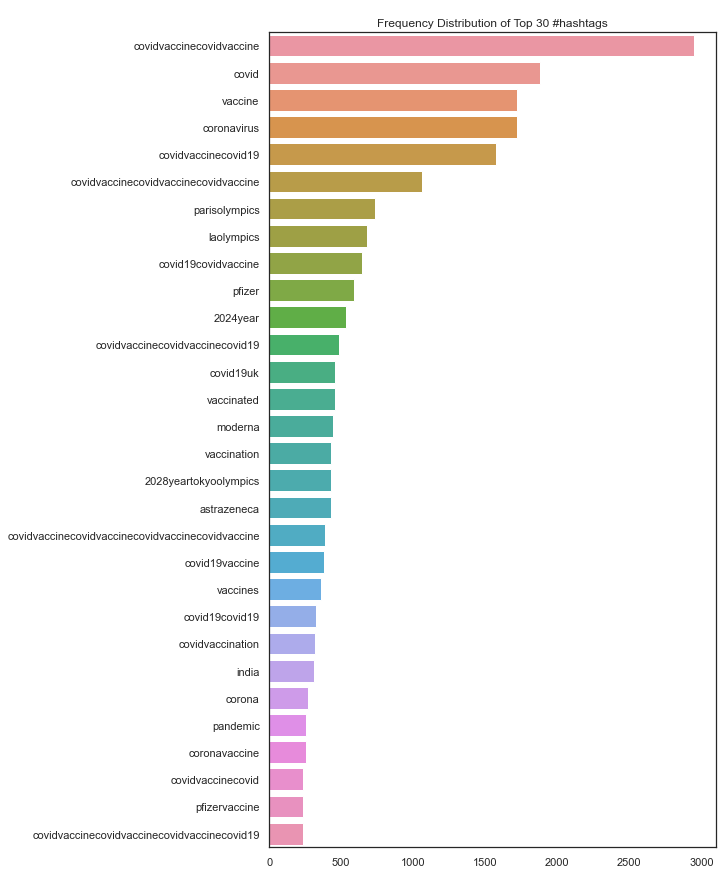

In [34]:
# frequency distinct: top 30 hashtags 
all_hashtags = ''.join(df['clean_hashtags'].values)
token_hashtag = word_tokenize(all_hashtags)
fdist_hash = FreqDist(token_hashtag).most_common(33)
fseries_hash = pd.Series(dict(fdist_hash[3:33]))
print('Frequency Distinct - top 30 #hashtags:\n')
print(fdist_hash)

# frequency distribution plot
fig,ax = plt.subplots(figsize=(8,15))
sns.barplot(y=fseries_hash.index,x=fseries_hash.values,ax=ax,orient='h')
plt.title('\nFrequency Distribution of Top 30 #hashtags')
plt.tight_layout;

<br>

***

- **Note:** Most of the top hashtags are quite generic/neutral such as #covidvaccine, #covidvaccination, #pfizer, etc. Unfortunately, this doesn't tell us much about sentiment.  This could be a result of pulling the tweets using the search word '#covidvaccine'. If there were more hashtags like '#vaccinated', which is ranked 14 on the top hashtags list, we could infer more about users' sentiment.

***

In [35]:
print(df['clean_text'].loc[df['clean_hashtags']=='vaccinated'].unique()[:15])

['wow that report is from the 15th 18th who were vaccinated lots of side effects in a very short time not countin'
 'the line of hope and promise to return to some sense of normalcy happy to see so many getting vaccinated feeling'
 'if you want people to willingly be vaccinated u need 2 do everything 2 gain the trust of the public delaying the'
 'thanks for sharing your vaccinated story consider sharing here'
 'so conehead donnelly thinks well have 15m vaccinated in q1 and the same in q2 thats barely 3 million out of a'
 'germany has vaccinated 84000 people in one day the total is 842455 or 1 of the populationthere are still'
 'dr peter cooper former treasurer of urges everyone to get vaccinated as soon as the vaccine becomes'
 'a great overview of the percentage of the us citizens vaccinated by state something to reference if youre measu'
 'more than 31k hoosiers were vaccinated yesterday including nearly 8k getting their second and final shot 18 of'
 'hopeful this will prove true let

<br>

***

- **Note:** Taking a deeper look into tweets with the hashtag '#vaccinated', we can confirm that these tweets imply postive sentiment.

***

## 7. WordClouds 

### 7.1 Entire Corpus - Tokens & Hashtags

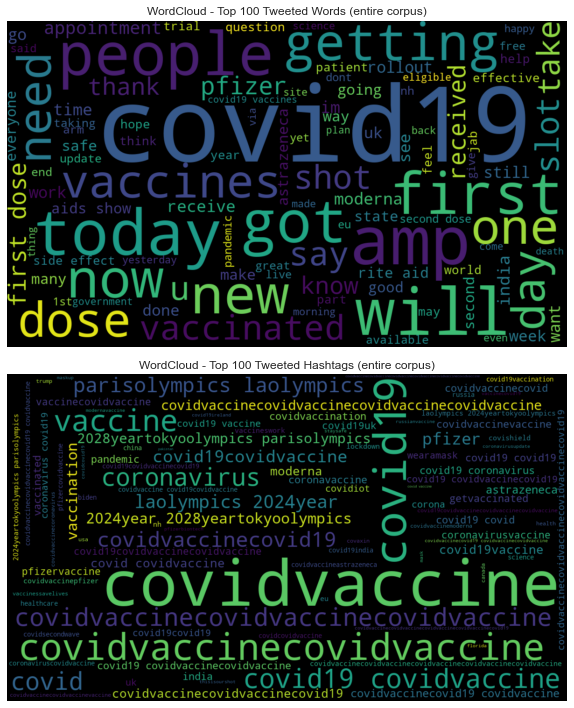

In [36]:
# WordCloud for top 100 tweets
stop_words_tweets = set(STOPWORDS)
stop_words_tweets.update(['covidvaccine','covid','19','coronavirus','vaccine','vaccination'])
wordcloud_tweets = WordCloud(width=1200,height=700,max_words=100,stopwords=stop_words_tweets).generate(all_tweets)

# WordCloud for top 100 hashtags
stop_words_hashtags = set(STOPWORDS)
wordcloud_hashtags = WordCloud(width=1200,height=700,max_words=100,stopwords=stop_words_hashtags).generate(all_hashtags)

fig,ax = plt.subplots(2,1,figsize=(15,10)) 
ax[0].imshow(wordcloud_tweets,interpolation='bilinear'); ax[0].axis('off')
ax[0].set_title('WordCloud - Top 100 Tweeted Words (entire corpus)')
ax[1].imshow(wordcloud_hashtags,interpolation='bilinear'); ax[1].axis('off')
ax[1].set_title('WordCloud - Top 100 Tweeted Hashtags (entire corpus)')
plt.tight_layout();

In [37]:
# wordcloud_tweets = WordCloud(width=1200,height=700,max_words=100,stopwords=stop_words_tweets,background_color ='white').generate(all_tweets)
# wordcloud_hashtags = WordCloud(width=1200,height=700,max_words=100,stopwords=stop_words_hashtags,background_color ='white').generate(all_hashtags)

# fig,ax = plt.subplots(1,2,figsize=(30,30)) 
# ax[0].imshow(wordcloud_tweets,interpolation='bilinear'); ax[0].axis('off')
# ax[0].set_title('Top 100 Tweeted Words (entire corpus)',fontsize=25)
# ax[1].imshow(wordcloud_hashtags,interpolation='bilinear'); ax[1].axis('off')
# ax[1].set_title('Top 100 Tweeted Hashtags (entire corpus)',fontsize=25)
# plt.tight_layout();
# # plt.savefig('../images/wc_corpus.png')

### 7.2 Sample(n=1000): positive, negative, neutral

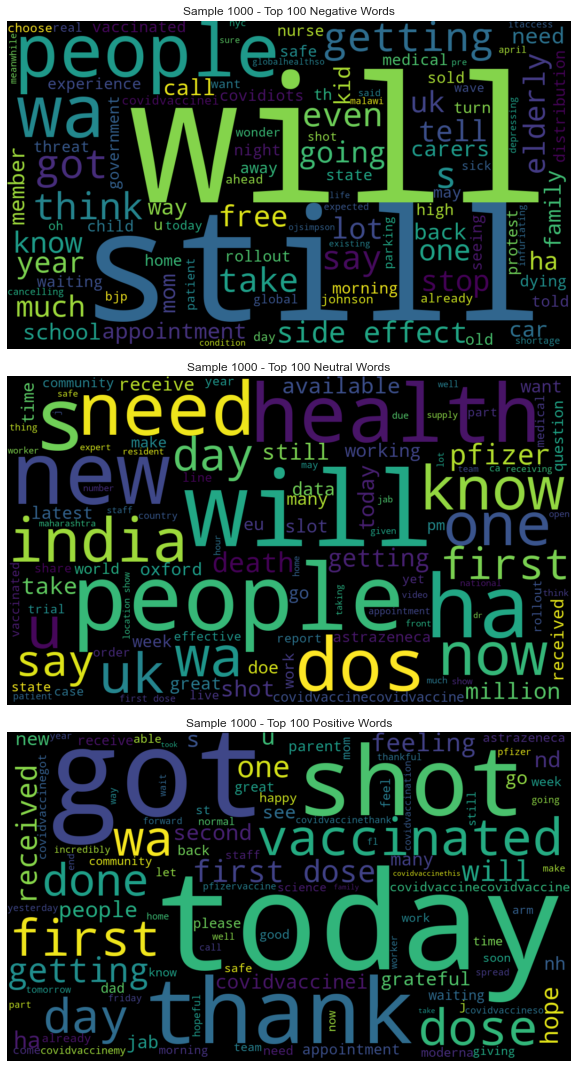

In [38]:
df_factop1k = pd.read_csv('../data/1000_lab6.csv')
factop1k_cleaned = df_factop1k[['clean_tweets','label','classes','classes2']]
factop1k_cleaned2 = factop1k_cleaned.copy()
factop1k_cleaned2['classes2'] = factop1k_cleaned2['classes2'].replace(3,1)

neg1000 = factop1k_cleaned2[factop1k_cleaned2.classes2==0]
neu1000 = factop1k_cleaned2[factop1k_cleaned2.classes2==1]
pos1000 = factop1k_cleaned2[factop1k_cleaned2.classes2==2]

neg1k_tweets = ''.join(neg1000['clean_tweets'].values)
neu1k_tweets = ''.join(neu1000['clean_tweets'].values)
pos1k_tweets = ''.join(pos1000['clean_tweets'].values)

wc1k_neg = WordCloud(width=1200,height=700,max_words=100,stopwords=stop_words_tweets).generate(neg1k_tweets)
wc1k_neu = WordCloud(width=1200,height=700,max_words=100,stopwords=stop_words_tweets).generate(neu1k_tweets)
wc1k_pos = WordCloud(width=1200,height=700,max_words=100,stopwords=stop_words_tweets).generate(pos1k_tweets)

fig,ax = plt.subplots(3,1,figsize=(25,15)) 
ax[0].imshow(wc1k_neg,interpolation='bilinear'); ax[0].axis('off')
ax[0].set_title('Sample 1000 - Top 100 Negative Words')
ax[1].imshow(wc1k_neu,interpolation='bilinear'); ax[1].axis('off')
ax[1].set_title('Sample 1000 - Top 100 Neutral Words')
ax[2].imshow(wc1k_pos,interpolation='bilinear'); ax[2].axis('off')
ax[2].set_title('Sample 1000 - Top 100 Positive Words')
plt.tight_layout();

# wc1k_neg = WordCloud(width=1200,height=700,max_words=100,background_color ='white',stopwords=stop_words_tweets).generate(neg1k_tweets)
# plt.imshow(wc1k_neg,interpolation='bilinear')
# plt.axis('off')
# plt.title('Sample 1000 - Top 100 Negative Words')
# plt.tight_layout();
# # plt.savefig('../images/wc1000_neg.png')

# wc1k_neu = WordCloud(width=1200,height=700,max_words=100,background_color ='white',stopwords=stop_words_tweets).generate(neu1k_tweets)
# plt.imshow(wc1k_neu,interpolation='bilinear')
# plt.axis('off')
# plt.title('Sample 1000 - Top 100 Neutral Words')
# plt.tight_layout();
# # plt.savefig('../images/wc1000_neu.png')

# wc1k_pos = WordCloud(width=1200,height=700,max_words=100,background_color ='white',stopwords=stop_words_tweets).generate(pos1k_tweets)
# plt.imshow(wc1k_pos,interpolation='bilinear')
# plt.axis('off')
# plt.title('Sample 1000 - Top 100 Positive Words')
# plt.tight_layout();
# # plt.savefig('../images/wc1000_pos.png')

# fig,ax = plt.subplots(1,3,figsize=(30,30)) 
# ax[0].imshow(wc1k_neg,interpolation='bilinear'); ax[0].axis('off')
# ax[0].set_title('Top 100 Negative Words',fontsize=20)
# ax[1].imshow(wc1k_neu,interpolation='bilinear'); ax[1].axis('off')
# ax[1].set_title('Top 100 Neutral Words',fontsize=20)
# ax[2].imshow(wc1k_pos,interpolation='bilinear'); ax[2].axis('off')
# ax[2].set_title('Top 100 Positive Words',fontsize=20)
# plt.tight_layout();
# # plt.savefig('../images/wc1000.png')

## 8. NLP Feature Engineering

### 8.1 Creating Text Features: char_count, word_count, avg_word_length

In [39]:
def new_text_feats(dfx,txt_col):
        dfx['char_count'] = dfx[txt_col].str.len()
        dfx['word_count'] = dfx[txt_col].str.split().str.len()
        dfx['avg_word_length'] = dfx['char_count']/dfx['word_count']

In [40]:
new_text_feats(df,'clean_text')
new_text_feats(factop1k_cleaned,'clean_tweets')

factop1k_cleaned2 = factop1k_cleaned.copy()
factop1k_cleaned2['classes2'] = factop1k_cleaned2['classes2'].replace(3,1)

In [41]:
df[['clean_text','char_count','word_count','avg_word_length']].head(10)

,clean_text,char_count,word_count,avg_word_length
0,dont politicize the cdc and the fda im perfect...,97,18,5.388889
1,whomever the president is needs to get the cov...,84,16,5.250000
2,you forgot to mention 5 million in funding fir...,85,15,5.666667
3,is trump pressuring fda for an october covidva...,75,11,6.818182
4,here we go covidvaccine,23,4,5.750000
5,its a scamdemic and only the sheeple who wear ...,87,16,5.437500
6,yet fauci is saying a vaccine might not help d...,97,21,4.619048
7,step up to the plate initiate a uniteforfreedo...,101,16,6.312500
8,consider enrolling in this covid19 covidvaccin...,107,17,6.294118
9,meanwhile in canada normalcy and true leadersh...,68,9,7.555556


In [42]:
df[['char_count','word_count','avg_word_length']].describe()

,char_count,word_count,avg_word_length
count,135322.000000,135322.000000,135322.000000
mean,90.265840,14.243929,6.655301
std,22.961728,4.760519,1.546477
min,5.000000,1.000000,2.666667
25%,78.000000,11.000000,5.684211
50%,98.000000,15.000000,6.333333
75%,108.000000,18.000000,7.222222
max,141.000000,31.000000,95.000000


### 8.2 Histogram/Density Plots w/ New Text Features

In [43]:
def density_hist_plots(title,df_name,col_name,alpha):
    fig,ax = plt.subplots(2,3,figsize=(20,10))
    fig.suptitle(title,fontsize=23,fontweight="bold")
    for i in df_name[col_name].unique():
        sns.distplot(df_name[df_name[col_name]==i]['char_count'],hist=True,bins=10,
                     kde=False,hist_kws={"alpha":alpha},ax=ax[0][0])
        sns.distplot(df_name[df_name[col_name]==i]['char_count'],hist=False,
                     kde=True,kde_kws={"shade":True},ax=ax[1][0])
        sns.distplot(df_name[df_name[col_name]==i]['word_count'],hist=True,bins=10,
                     kde=False,hist_kws={"alpha":alpha},ax=ax[0][1])
        sns.distplot(df_name[df_name[col_name]==i]['word_count'],hist=False,
                     kde=True,kde_kws={"shade":True},ax=ax[1][1])
        sns.distplot(df_name[df_name[col_name]==i]['avg_word_length'],hist=True,bins=10,
                     kde=False,hist_kws={"alpha":alpha},ax=ax[0][2])
        sns.distplot(df_name[df_name[col_name]==i]['avg_word_length'],hist=False,
                     kde=True,kde_kws={"shade":True},ax=ax[1][2])     
        ax[0][0].grid(True); ax[0][0].legend(df_name[col_name].unique()); ax[0][0].set(xlabel='Histogram'); ax[0][0].set_title('char_count',fontsize=18,fontweight="bold")
        ax[1][0].grid(True); ax[1][0].legend(df_name[col_name].unique()); ax[1][0].set(ylabel=None); ax[1][0].set(xlabel='Density')
        ax[0][1].grid(True); ax[0][1].legend(df_name[col_name].unique()); ax[0][1].set(xlabel='Histogram'); ax[0][1].set_title('word_count',fontsize=18,fontweight="bold")
        ax[1][1].grid(True); ax[1][1].legend(df_name[col_name].unique()); ax[1][1].set(ylabel=None); ax[1][1].set(xlabel='Density')
        ax[0][2].grid(True); ax[0][2].legend(df_name[col_name].unique()); ax[0][2].set(xlabel='Histogram'); ax[0][2].set_title('avg_word_length',fontsize=18,fontweight="bold")
        ax[1][2].grid(True); ax[1][2].legend(df_name[col_name].unique()); ax[1][2].set(ylabel=None); ax[1][2].set(xlabel='Density')
        plt.tight_layout();

### 8.2.1 Sample(n=1000) w/ 3 classes: positive, negative, neutral

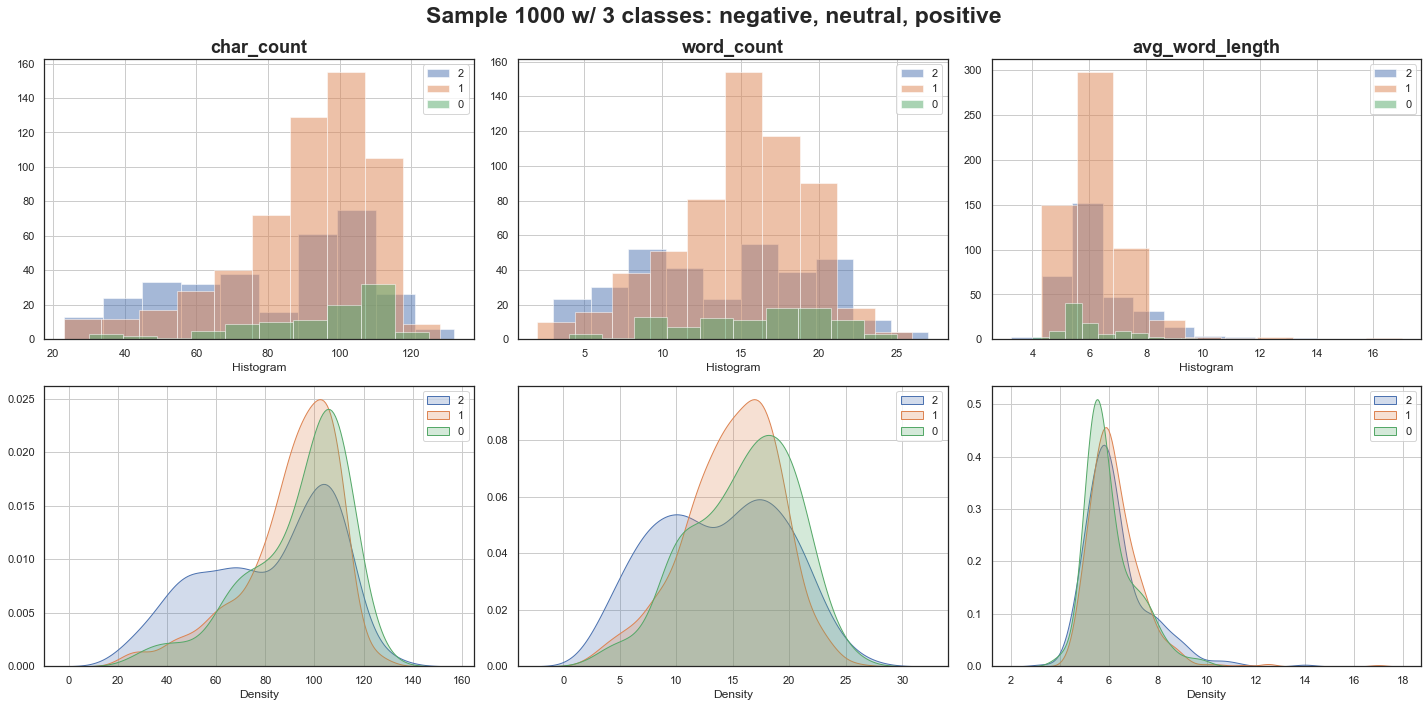

In [44]:
title1 = 'Sample 1000 w/ 3 classes: negative, neutral, positive'
df_name1 = factop1k_cleaned2
col_name1 = 'classes2'
density_hist_plots(title1,df_name1,col_name1,0.5)

### 8.2.2 Sample(n=1000) w/ 4 classes: positive, negative, neutral, F/A

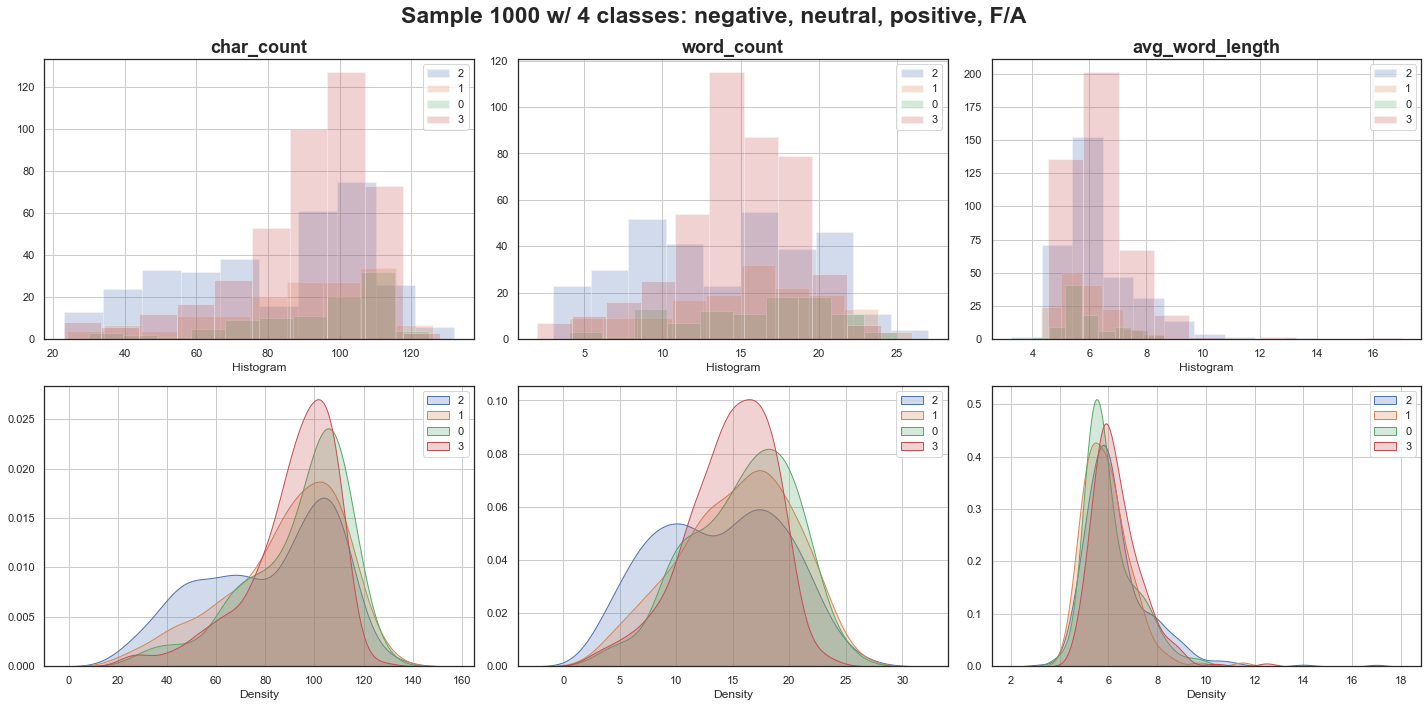

In [45]:
title2 = 'Sample 1000 w/ 4 classes: negative, neutral, positive, F/A'
df_name2 = factop1k_cleaned
col_name2 = 'classes2'
density_hist_plots(title2,df_name2,col_name2,0.25)